In [1]:
!pip install tensorflow keras opencv-python pandas numpy scikit-learn kaggle

In [2]:
!pip install matplotlib PyTorch

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for PyTorch
  Running setup.py clean for PyTorch
Failed to build PyTorch
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (PyTorch)


In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is 

Cargando el dataset EmoSet-118K...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/18 [00:00<?, ?it/s]

Dataset cargado - Tamaños: Entrenamiento=94481, Validación=5905, Prueba=17716


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Distribución de clases en el dataset de entrenamiento:


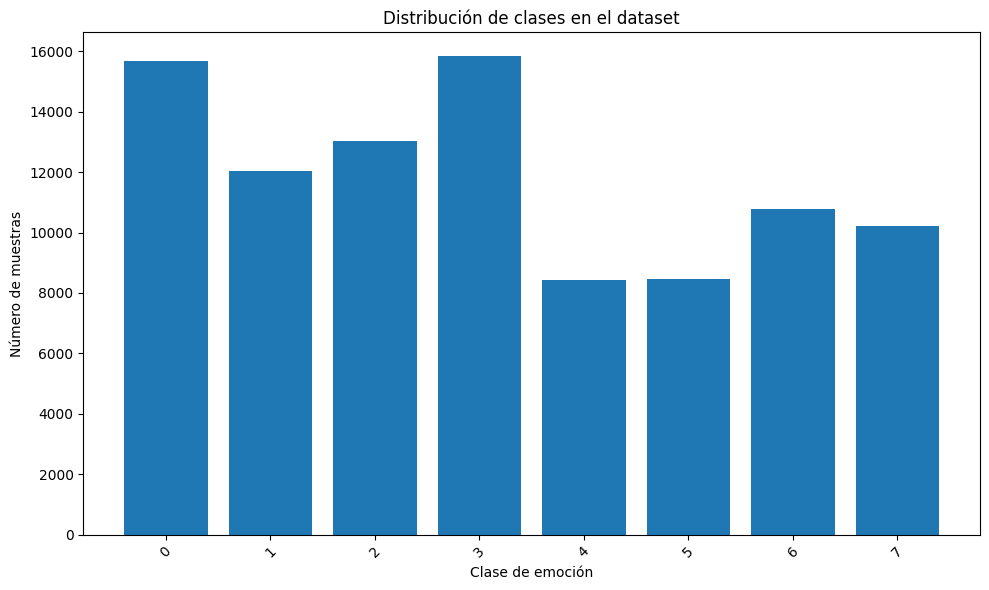


Pesos de las clases para manejar el desbalance:
Clase 0: 0.7531
Clase 1: 0.9824
Clase 2: 0.9060
Clase 3: 0.7457
Clase 4: 1.4003
Clase 5: 1.3948
Clase 6: 1.0949
Clase 7: 1.1558


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Forma de un batch de imágenes: torch.Size([32, 3, 224, 224])
Etiquetas correspondientes: tensor([1, 4, 6, 5, 1, 6, 5, 5, 4, 4, 4, 0, 6, 5, 4, 6, 5, 4, 2, 6, 0, 4, 2, 4,
        5, 3, 3, 3, 3, 5, 0, 3])


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

#Definir las clases de emociones
CLASES_EMOCIONES = ['amusement', 'excitement', 'anger', 'fear', 'sadness', 'contentment', 'awe', 'disgust']

#Función para cargar y preparar el dataset
def cargar_dataset():
    print("Cargando el dataset EmoSet-118K...")
    ds = load_dataset("Woleek/EmoSet-118K")

    # Acceder a las particiones
    train_ds = ds['train']
    val_ds = ds['val']
    test_ds = ds['test']

    print(f"Dataset cargado - Tamaños: Entrenamiento={len(train_ds)}, Validación={len(val_ds)}, Prueba={len(test_ds)}")

    return train_ds, val_ds, test_ds

def crear_transformaciones(tamaño_imagen=224):
    #Transformaciones para entrenamiento (con data augmentation)
    transform_train = transforms.Compose([
        transforms.Resize((tamaño_imagen, tamaño_imagen)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    #Transformaciones para validación y prueba (sin data augmentation)
    transform_val = transforms.Compose([
        transforms.Resize((tamaño_imagen, tamaño_imagen)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return transform_train, transform_val

#Clase para crear secuencias de imágenes para LSTM
class GeneradorSecuencias:
    def __init__(self, dataset, longitud_secuencia=10, solapamiento=5):
        """
        Genera secuencias para el modelo LSTM
        :param dataset: Dataset de imágenes
        :param longitud_secuencia: Número de frames en cada secuencia
        :param solapamiento: Número de frames que se solapan entre secuencias consecutivas
        """
        self.dataset = dataset
        self.longitud_secuencia = longitud_secuencia
        self.solapamiento = solapamiento

        # Agrupar muestras por clase
        self.muestras_por_clase = {}
        for i, muestra in enumerate(dataset):
            clase = muestra['label']
            if clase not in self.muestras_por_clase:
                self.muestras_por_clase[clase] = []
            self.muestras_por_clase[clase].append(i)

    def generar_secuencias_balanceadas(self, num_secuencias_por_clase=100):
        """
        Genera secuencias balanceadas para cada clase
        """
        secuencias = []
        etiquetas = []

        for clase, indices in self.muestras_por_clase.items():
            #Generar secuencias aleatorias para cada clase
            for _ in range(num_secuencias_por_clase):
                #Seleccionar aleatoriamente el inicio de la secuencia
                if len(indices) >= self.longitud_secuencia:
                    inicio = np.random.randint(0, len(indices) - self.longitud_secuencia + 1)
                    indices_secuencia = indices[inicio:inicio + self.longitud_secuencia]
                else:
                    #Si no hay suficientes imágenes, repetir algunas
                    indices_secuencia = np.random.choice(indices, size=self.longitud_secuencia, replace=True)

                secuencias.append(indices_secuencia)
                etiquetas.append(clase)

        return secuencias, etiquetas

#Función para calcular los pesos de las clases para manejar el desbalance
def calcular_pesos_clases(dataset):
    etiquetas = [muestra['label'] for muestra in dataset]
    pesos = compute_class_weight(class_weight='balanced',
                                classes=np.unique(etiquetas),
                                y=etiquetas)
    return dict(zip(np.unique(etiquetas), pesos))

#Función para visualizar la distribución de clases
def visualizar_distribucion_clases(dataset):
    conteo_clases = {}
    for muestra in dataset:
        clase = muestra['label']
        if clase not in conteo_clases:
            conteo_clases[clase] = 0
        conteo_clases[clase] += 1

    plt.figure(figsize=(10, 6))
    plt.bar(conteo_clases.keys(), conteo_clases.values())
    plt.title('Distribución de clases en el dataset')
    plt.xlabel('Clase de emoción')
    plt.ylabel('Número de muestras')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return conteo_clases

#Clase para cargar y procesar el dataset para PyTorch
class DatasetEmociones(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        muestra = self.dataset[idx]
        imagen = muestra['image']
        etiqueta = muestra['label']

        # Aplicar transformaciones si se proporcionan
        if self.transform:
            imagen = self.transform(imagen)

        # No es necesario convertir la etiqueta ya que ya es un índice numérico
        etiqueta_idx = etiqueta  # Directamente utilizamos la etiqueta numérica

        return imagen, etiqueta_idx

#Función para crear dataloaders
def crear_dataloaders(train_ds, val_ds, test_ds, transform_train, transform_val, batch_size=32):
    train_dataset = DatasetEmociones(train_ds, transform_train)
    val_dataset = DatasetEmociones(val_ds, transform_val)
    test_dataset = DatasetEmociones(test_ds, transform_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

#Función principal para preprocesar el dataset
def preprocesar_dataset(batch_size=32, tamaño_imagen=224):
    #Cargar dataset
    train_ds, val_ds, test_ds = cargar_dataset()

    #Crear transformaciones
    transform_train, transform_val = crear_transformaciones(tamaño_imagen)

    #Crear dataloaders
    train_loader, val_loader, test_loader = crear_dataloaders(
        train_ds, val_ds, test_ds, transform_train, transform_val, batch_size
    )

    #Calcular pesos de clases para manejar el desbalance
    pesos_clases = calcular_pesos_clases(train_ds)

    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'pesos_clases': pesos_clases,
        'datasets': {
            'train': train_ds,
            'val': val_ds,
            'test': test_ds
        }
    }

if __name__ == "__main__":
    #Preprocesar el dataset
    resultado = preprocesar_dataset(batch_size=32)

    #Visualizar la distribución de clases
    print("Distribución de clases en el dataset de entrenamiento:")
    conteo_clases = visualizar_distribucion_clases(resultado['datasets']['train'])

    #Mostrar los pesos de las clases
    print("\nPesos de las clases para manejar el desbalance:")
    for clase, peso in resultado['pesos_clases'].items():
        print(f"Clase {clase}: {peso:.4f}")

    #Mostrar una muestra del dataset
    train_iter = iter(resultado['train_loader'])
    images, labels = next(train_iter)
    print(f"\nForma de un batch de imágenes: {images.shape}")
    print(f"Etiquetas correspondientes: {labels}")

GPU encontrada para TensorFlow
Se han configurado 1 GPUs para uso con crecimiento de memoria dinámico
Cargando el dataset EmoSet-118K...


Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/18 [00:00<?, ?it/s]

Dataset cargado - Tamaños: Entrenamiento=94481, Validación=5905, Prueba=17716
Distribución de clases en el dataset de entrenamiento:


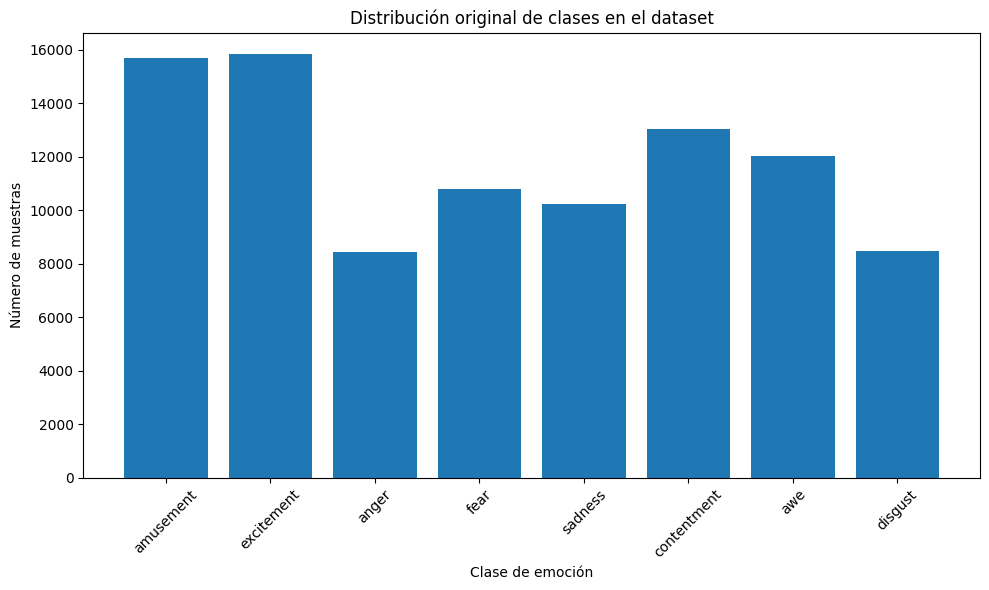

Pesos calculados para equilibrar las clases:
Clase amusement: 0.7531
Clase fear: 0.7457
Clase sadness: 1.4003
Clase awe: 1.0949
Clase disgust: 1.1558
Clase anger: 0.9060
Clase excitement: 0.9824
Clase contentment: 1.3948
Usando batch_size=64 optimizado para el hardware disponible
Convirtiendo datos al formato TensorFlow con data augmentation (48x48, grayscale)...
Clase amusement: 15681 muestras originales
Clase excitement: 12022 muestras originales
Clase anger: 13036 muestras originales
Clase fear: 15837 muestras originales
Clase sadness: 8434 muestras originales
Clase contentment: 8467 muestras originales
Clase awe: 10786 muestras originales
Clase disgust: 10218 muestras originales
Convirtiendo conjunto de validación...
Convirtiendo conjunto de prueba...
Creando modelo con shape de entrada: (48, 48, 1)
Entrenamiento en un solo dispositivo
Modelo compilado correctamente


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 44, 44, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 44, 44, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 44, 44, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 22, 22, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 22, 22, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 11, 11, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 11, 11, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 5, 5, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 5, 5, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,796,232 (14.48 MB)

 Trainable params: 3,792,264 (14.47 MB)

 Non-trainable params: 3,968 (15.50 KB)

Iniciando entrenamiento...
Epoch 1/40
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1865 - loss: 4.4879
Epoch 1: val_accuracy improved from -inf to 0.14564, saving model to mejor_modelo_emociones.h5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step - accuracy: 0.1865 - loss: 4.4877 - val_accuracy: 0.1456 - val_loss: 4.0706
Epoch 2/40
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2256 - loss: 4.0475
Epoch 2: val_accuracy improved from 0.14564 to 0.15038, saving model to mejor_modelo_emociones.h5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.2256 - loss: 4.0474 - val_accuracy: 0.1504 - val_loss: 3.9814
Epoch 3/40
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2456 - loss: 3.7602
Epoch 3: val_accuracy did not improve from 0.15038
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.2456 - loss: 3.7600 - val_accuracy: 0.1433 - val_loss: 3.9383
Epoch 4/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2629 - loss: 3.5369
Epoch 4: val_accuracy did not improve from 0.15038
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.2629 - loss: 3.5368 - val_accuracy: 0.1360 - val_loss: 4.0551
Epoch 5/40
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2813 - loss: 3.3351
Epoch 5: val_accuracy did not improve from 0.15038
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.2813 - loss: 3.3350 - val_accuracy: 0.1494 - val_loss: 3.7755
Epoch 6/40
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2918 - loss: 3.1661
Epoch 6

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.2918 - loss: 3.1660 - val_accuracy: 0.1956 - val_loss: 3.4366
Epoch 7/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3027 - loss: 3.0318
Epoch 7: val_accuracy improved from 0.19560 to 0.20423, saving model to mejor_modelo_emociones.h5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.3027 - loss: 3.0317 - val_accuracy: 0.2042 - val_loss: 3.2560
Epoch 8/40
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3127 - loss: 2.9041
Epoch 8: val_accuracy improved from 0.20423 to 0.21406, saving model to mejor_modelo_emociones.h5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.3127 - loss: 2.9040 - val_accuracy: 0.2141 - val_loss: 3.1333
Epoch 9/40
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3231 - loss: 2.7985
Epoch 9: val_accuracy improved from 0.21406 to 0.24285, saving model to mejor_modelo_emociones.h5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.3231 - loss: 2.7984 - val_accuracy: 0.2428 - val_loss: 2.9628
Epoch 10/40
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3291 - loss: 2.7033
Epoch 10: val_accuracy did not improve from 0.24285
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.3291 - loss: 2.7032 - val_accuracy: 0.2215 - val_loss: 3.0211
Epoch 11/40
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3366 - loss: 2.6119
Epoch 11: val_accuracy did not improve from 0.24285
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.3366 - loss: 2.6119 - val_accuracy: 0.2352 - val_loss: 2.9277
Epoch 12/40
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3381 - loss: 2.5455
Epoch 12: val_accuracy improved from 0.24285 to 0.28400, saving model to mejor_modelo_emociones.h5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.3381 - loss: 2.5454 - val_accuracy: 0.2840 - val_loss: 2.6669
Epoch 13/40
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3430 - loss: 2.4761
Epoch 13: val_accuracy did not improve from 0.28400
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.3430 - loss: 2.4761 - val_accuracy: 0.2564 - val_loss: 2.7229
Epoch 14/40
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3520 - loss: 2.4127
Epoch 14: val_accuracy did not improve from 0.28400
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.3520 - loss: 2.4127 - val_accuracy: 0.2601 - val_loss: 2.6641
Epoch 15/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3537 - loss: 2.3590
Epoch 15: val_accuracy did not improve from 0.28400
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.3537 - loss: 2.3589 - val_accuracy: 0.2689 - val_loss: 2.6502
Epoch 16/40
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3610 - loss: 2.3008


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.3610 - loss: 2.3008 - val_accuracy: 0.3087 - val_loss: 2.3630
Epoch 17/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3630 - loss: 2.2597
Epoch 17: val_accuracy did not improve from 0.30872
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.3630 - loss: 2.2597 - val_accuracy: 0.3035 - val_loss: 2.3597
Epoch 18/40
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3685 - loss: 2.2184
Epoch 18: val_accuracy improved from 0.30872 to 0.31465, saving model to mejor_modelo_emociones.h5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.3685 - loss: 2.2183 - val_accuracy: 0.3146 - val_loss: 2.3172
Epoch 19/40
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3747 - loss: 2.1740
Epoch 19: val_accuracy improved from 0.31465 to 0.31651, saving model to mejor_modelo_emociones.h5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.3747 - loss: 2.1740 - val_accuracy: 0.3165 - val_loss: 2.2948
Epoch 20/40
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3810 - loss: 2.1403
Epoch 20: val_accuracy did not improve from 0.31651
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.3810 - loss: 2.1403 - val_accuracy: 0.3152 - val_loss: 2.2816
Epoch 21/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3828 - loss: 2.1032
Epoch 21: val_accuracy improved from 0.31651 to 0.32210, saving model to mejor_modelo_emociones.h5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.3828 - loss: 2.1032 - val_accuracy: 0.3221 - val_loss: 2.2430
Epoch 22/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3861 - loss: 2.0727
Epoch 22: val_accuracy improved from 0.32210 to 0.35021, saving model to mejor_modelo_emociones.h5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.3861 - loss: 2.0727 - val_accuracy: 0.3502 - val_loss: 2.1485
Epoch 23/40
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3947 - loss: 2.0437
Epoch 23: val_accuracy did not improve from 0.35021
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.3947 - loss: 2.0437 - val_accuracy: 0.3328 - val_loss: 2.1844
Epoch 24/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4009 - loss: 2.0132
Epoch 24: val_accuracy did not improve from 0.35021
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.4009 - loss: 2.0132 - val_accuracy: 0.3333 - val_loss: 2.1863
Epoch 25/40
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4017 - loss: 1.9887
Epoch 25: val_accuracy did not improve from 0.35021
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.4017 - loss: 1.9887 - val_accuracy: 0.3431 - val_loss: 2.1095
Epoch 26/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4073 - loss: 1.9654


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.4098 - loss: 1.9429 - val_accuracy: 0.3573 - val_loss: 2.0610
Epoch 28/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4141 - loss: 1.9205
Epoch 28: val_accuracy improved from 0.35732 to 0.35902, saving model to mejor_modelo_emociones.h5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.4141 - loss: 1.9205 - val_accuracy: 0.3590 - val_loss: 2.0718
Epoch 29/40
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4172 - loss: 1.9012
Epoch 29: val_accuracy improved from 0.35902 to 0.37324, saving model to mejor_modelo_emociones.h5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.4172 - loss: 1.9012 - val_accuracy: 0.3732 - val_loss: 1.9974
Epoch 30/40
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4214 - loss: 1.8831
Epoch 30: val_accuracy did not improve from 0.37324
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.4214 - loss: 1.8831 - val_accuracy: 0.3655 - val_loss: 2.0302
Epoch 31/40
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4290 - loss: 1.8592
Epoch 31: val_accuracy did not improve from 0.37324
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.4290 - loss: 1.8592 - val_accuracy: 0.3626 - val_loss: 2.0344
Epoch 32/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4331 - loss: 1.8429
Epoch 32: val_accuracy improved from 0.37324 to 0.38036, saving model to mejor_modelo_emociones.h5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.4331 - loss: 1.8429 - val_accuracy: 0.3804 - val_loss: 1.9581
Epoch 33/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4374 - loss: 1.8234
Epoch 33: val_accuracy did not improve from 0.38036
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.4374 - loss: 1.8234 - val_accuracy: 0.3744 - val_loss: 1.9915
Epoch 34/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4393 - loss: 1.8131
Epoch 34: val_accuracy did not improve from 0.38036
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.4393 - loss: 1.8131 - val_accuracy: 0.3726 - val_loss: 2.0057
Epoch 35/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4449 - loss: 1.7996
Epoch 35: val_accuracy did not improve from 0.38036
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.4449 - loss: 1.7996 - val_accuracy: 0.3761 - val_loss: 1.9750
Epoch 36/40
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4504 - loss: 1.7786


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.4504 - loss: 1.7786 - val_accuracy: 0.3837 - val_loss: 1.9607
Epoch 37/40
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4581 - loss: 1.7628
Epoch 37: val_accuracy improved from 0.38374 to 0.38628, saving model to mejor_modelo_emociones.h5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.4581 - loss: 1.7628 - val_accuracy: 0.3863 - val_loss: 1.9494
Epoch 38/40
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4585 - loss: 1.7510
Epoch 38: val_accuracy improved from 0.38628 to 0.38984, saving model to mejor_modelo_emociones.h5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.4585 - loss: 1.7510 - val_accuracy: 0.3898 - val_loss: 1.9332
Epoch 39/40
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4606 - loss: 1.7360
Epoch 39: val_accuracy did not improve from 0.38984
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.4606 - loss: 1.7360 - val_accuracy: 0.3688 - val_loss: 2.0257
Epoch 40/40
 998/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4661 - loss: 1.7273
Epoch 40: val_accuracy improved from 0.38984 to 0.39848, saving model to mejor_modelo_emociones.h5


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.4661 - loss: 1.7273 - val_accuracy: 0.3985 - val_loss: 1.9004
Restoring model weights from the end of the best epoch: 40.

Evaluando el modelo en el conjunto de prueba...
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4054 - loss: 1.8981
Precisión en el conjunto de prueba: 40.29%


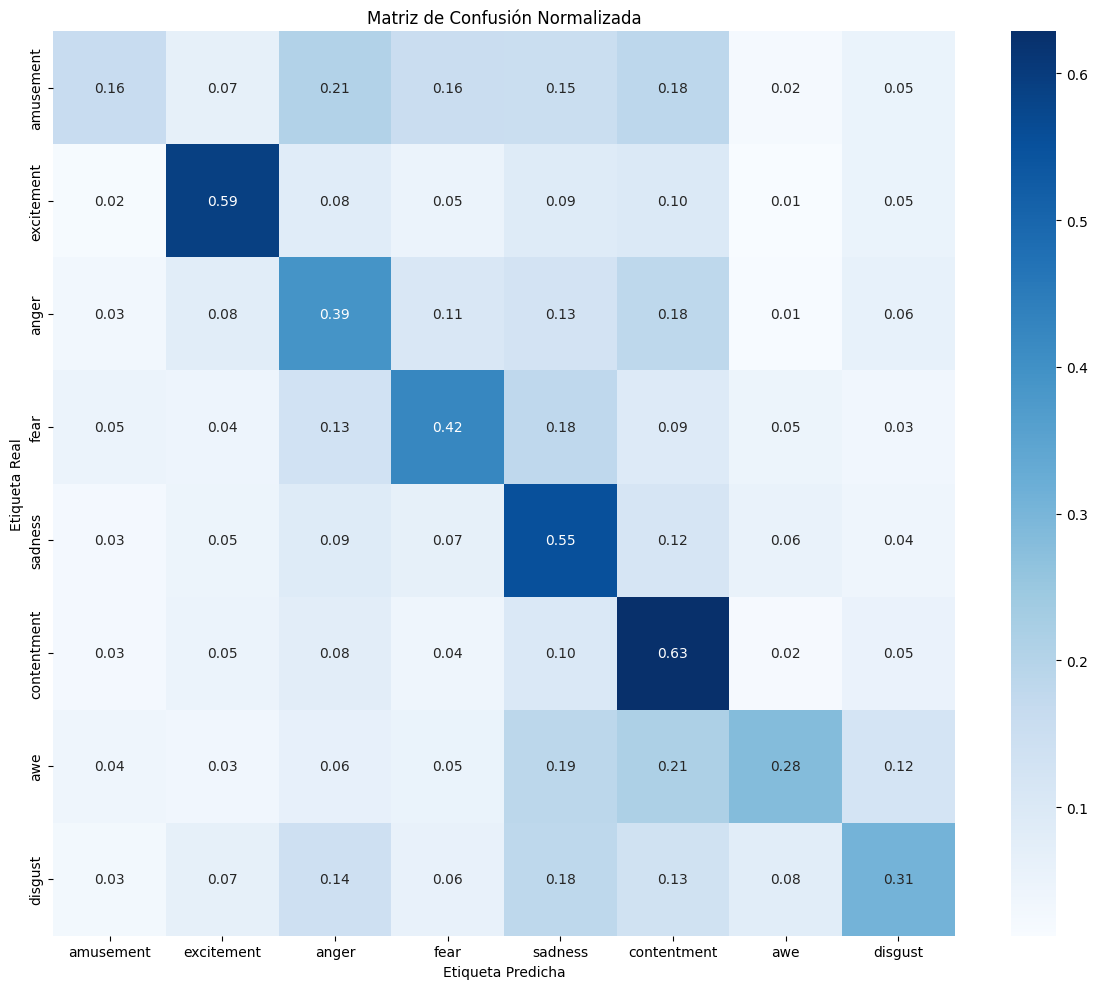


Reporte de clasificación:
              precision    recall  f1-score   support

   amusement       0.47      0.16      0.24      2770
  excitement       0.60      0.59      0.60      2260
       anger       0.35      0.39      0.37      2484
        fear       0.51      0.42      0.46      3014
     sadness       0.28      0.55      0.38      1708
 contentment       0.31      0.63      0.41      1661
         awe       0.50      0.28      0.36      1974
     disgust       0.38      0.31      0.34      1845

    accuracy                           0.40     17716
   macro avg       0.43      0.42      0.40     17716
weighted avg       0.44      0.40      0.39     17716

Modelo guardado como 'modelo_emociones_8000.h5'


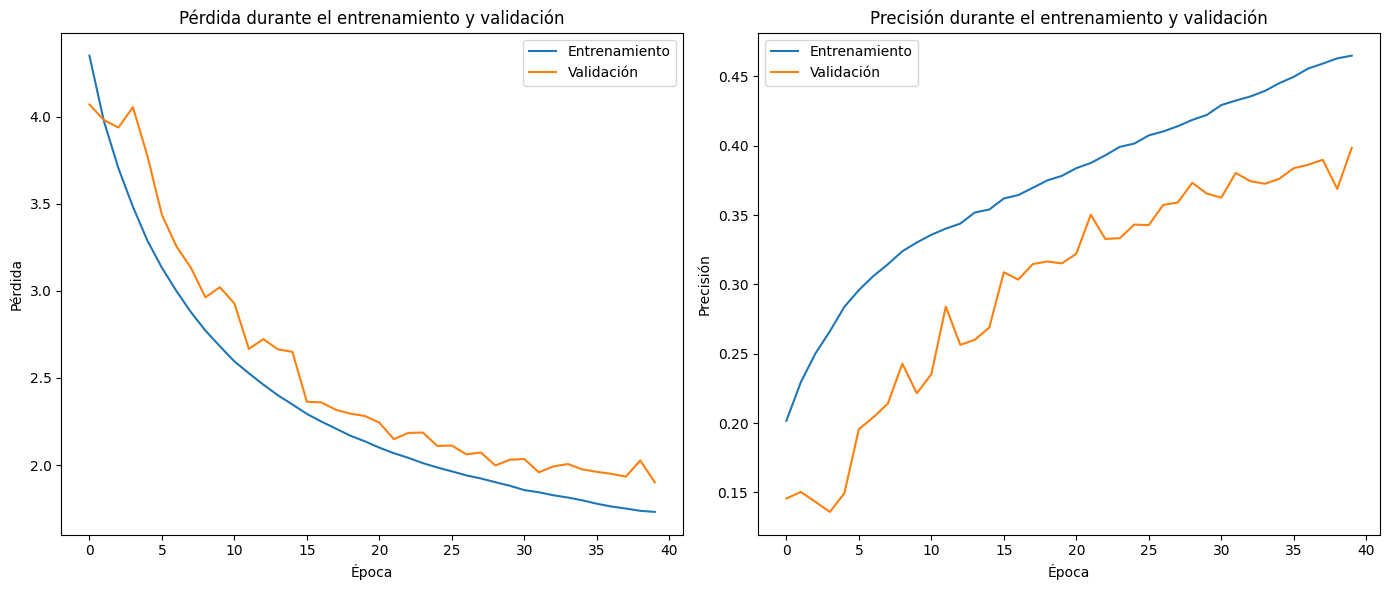

In [7]:
import os
import numpy as np
import torch
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Definir las clases de emociones
CLASES_EMOCIONES = ['amusement', 'excitement', 'anger', 'fear', 'sadness', 'contentment', 'awe', 'disgust']

#Verificar disponibilidad de GPU para TensorFlow
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU encontrada para TensorFlow")
    for gpu in gpus:
        # Permitir crecimiento de memoria según sea necesario
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"Se han configurado {len(gpus)} GPUs para uso con crecimiento de memoria dinámico")
else:
    print("No se encontró GPU para TensorFlow, utilizando CPU")

#Función para cargar y preparar el dataset
def cargar_dataset():
    from datasets import load_dataset
    print("Cargando el dataset EmoSet-118K...")
    ds = load_dataset("Woleek/EmoSet-118K")

    #Acceder a las particiones
    train_ds = ds['train']
    val_ds = ds['val']
    test_ds = ds['test']

    print(f"Dataset cargado - Tamaños: Entrenamiento={len(train_ds)}, Validación={len(val_ds)}, Prueba={len(test_ds)}")

    return train_ds, val_ds, test_ds

#Función para calcular pesos de clases para balanceo
def calcular_pesos_clases(conteo_clases):
    total_muestras = sum(conteo_clases.values())
    num_clases = len(conteo_clases)
    pesos_clases = {}

    for clase, cantidad in conteo_clases.items():
        # Calculamos el peso como: total / (num_clases * cantidad de la clase)
        pesos_clases[clase] = total_muestras / (num_clases * cantidad)

    return pesos_clases

# Función para aplicar data augmentation en GPU
def aplicar_augmentation_en_gpu(imagenes, etiquetas, clase_objetivo, max_muestras, batch_size=32):
    # Cantidad de imágenes adicionales a generar
    num_imagenes = len(imagenes)
    num_adicionales = max_muestras - num_imagenes

    if num_adicionales <= 0:
        return imagenes, etiquetas

    print(f"Generando {num_adicionales} muestras adicionales para clase {CLASES_EMOCIONES[clase_objetivo]} usando GPU...")

    # Configurar el generador de data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Convertir a tensores de TF y mover a GPU si está disponible
    with tf.device('/GPU:0' if len(gpus) > 0 else '/CPU:0'):
        # Crear dataset de TensorFlow
        tf_dataset = tf.data.Dataset.from_tensor_slices((imagenes, etiquetas))
        tf_dataset = tf_dataset.repeat()
        tf_dataset = tf_dataset.shuffle(buffer_size=1000)
        tf_dataset = tf_dataset.batch(batch_size)
        tf_dataset = tf_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

        # Función para aplicar augmentation a un lote
        def aumentar_lote(x, y):
            return next(datagen.flow(x.numpy(), y.numpy(), batch_size=batch_size, shuffle=False))

        # Función mapeable a TensorFlow
        def tf_aumentar_lote(x, y):
            [x_aug, y_aug] = tf.py_function(aumentar_lote, [x, y], [tf.float32, tf.float32])
            x_aug.set_shape([None, imagenes.shape[1], imagenes.shape[2], imagenes.shape[3]])
            y_aug.set_shape([None])
            return x_aug, y_aug

        # Aplicar augmentation y recolectar resultados
        aumentado_dataset = tf_dataset.map(tf_aumentar_lote,
                                        num_parallel_calls=tf.data.AUTOTUNE)

        # Recolectar muestras aumentadas
        nuevas_imagenes = []
        nuevas_etiquetas = []
        contador = 0

        for x_batch, y_batch in aumentado_dataset:
            nuevas_imagenes.append(x_batch.numpy())
            nuevas_etiquetas.append(y_batch.numpy())
            contador += len(x_batch)
            if contador >= num_adicionales:
                break

        # Concatenar y recortar al número exacto
        nuevas_imagenes_np = np.concatenate(nuevas_imagenes, axis=0)[:num_adicionales]
        nuevas_etiquetas_np = np.concatenate(nuevas_etiquetas, axis=0)[:num_adicionales]

        # Combinar originales + aumentadas
        return np.concatenate([imagenes, nuevas_imagenes_np], axis=0), np.concatenate([etiquetas, nuevas_etiquetas_np], axis=0)

#Función para convertir datos de PyTorch a TensorFlow con Data Augmentation
def pytorch_a_tensorflow_con_augmentation(dataset, batch_size=32, input_shape=(224, 224), tipo_imagen='rgb', conteo_clases=None, max_por_clase=None):
    """
    Convierte un dataset de PyTorch a un formato compatible con TensorFlow
    y aplica data augmentation para balancear las clases.
    """
    from torchvision import transforms

    # Determinar el número máximo de muestras por clase para equilibrar
    if conteo_clases and not max_por_clase:
        max_por_clase = 8000  # Fijamos a 8000 imágenes por clase
        print(f"Equilibrando las clases a {max_por_clase} muestras cada una...")
    elif not max_por_clase:
        max_por_clase = 8000  # Por defecto 8000 imágenes

    # Definir transformaciones según el tipo de imagen
    if tipo_imagen == 'grayscale':
        num_canales = 1
        transform = transforms.Compose([
            transforms.Resize(input_shape),
            transforms.Grayscale(),
            transforms.ToTensor(),
        ])
    else:  # RGB
        num_canales = 3
        transform = transforms.Compose([
            transforms.Resize(input_shape),
            transforms.ToTensor(),
        ])

    # Procesar las imágenes
    todas_imagenes = []
    todas_etiquetas = []

    for i in range(len(dataset)):
        muestra = dataset[i]
        imagen = muestra['image']
        etiqueta = muestra['label']

        # Aplicar transformaciones
        imagen_tensor = transform(imagen)

        # Convertir de tensor PyTorch a numpy
        if tipo_imagen == 'grayscale':
            imagen_np = imagen_tensor.numpy().squeeze()
            imagen_np = imagen_np.reshape(input_shape[0], input_shape[1], 1)
        else:
            imagen_np = imagen_tensor.numpy().transpose(1, 2, 0)

        todas_imagenes.append(imagen_np)
        todas_etiquetas.append(etiqueta)

    # Convertir a arrays numpy
    x_data = np.array(todas_imagenes)
    y_data = np.array(todas_etiquetas)

    # Normalización
    if x_data.max() > 1.0:
        x_data = x_data / 255.0

    if conteo_clases:
        # Organizar por clase
        x_por_clase = {}
        y_por_clase = {}

        for clase in range(len(CLASES_EMOCIONES)):
            indices = np.where(y_data == clase)[0]
            x_por_clase[clase] = x_data[indices]
            y_por_clase[clase] = y_data[indices]

            print(f"Clase {CLASES_EMOCIONES[clase]}: {len(indices)} muestras originales")

        # Aplicar augmentation en GPU para clases desbalanceadas
        x_balanceado = []
        y_balanceado = []

        for clase in range(len(CLASES_EMOCIONES)):
            if len(x_por_clase[clase]) > 0:
                # Crear arrays de etiquetas para la clase
                etiquetas_clase = np.full(len(x_por_clase[clase]), clase)

                # Aplicar augmentation si es necesario
                if len(x_por_clase[clase]) < max_por_clase:
                    x_aumentado, y_aumentado = aplicar_augmentation_en_gpu(
                        x_por_clase[clase], etiquetas_clase, clase, max_por_clase, batch_size
                    )
                    x_balanceado.append(x_aumentado)
                    y_balanceado.append(y_aumentado)
                else:
                    # Si ya tenemos suficientes muestras, limitamos a max_por_clase
                    indices_limite = np.random.choice(len(x_por_clase[clase]), min(max_por_clase, len(x_por_clase[clase])), replace=False)
                    x_balanceado.append(x_por_clase[clase][indices_limite])
                    y_balanceado.append(etiquetas_clase[indices_limite])

        # Concatenar todas las clases
        x_data = np.concatenate(x_balanceado, axis=0)
        y_data = np.concatenate(y_balanceado, axis=0)

    # Mezclar datos
    indices = np.arange(len(x_data))
    np.random.shuffle(indices)
    x_data = x_data[indices]
    y_data = y_data[indices]

    # Convertir etiquetas a formato one-hot
    num_clases = len(CLASES_EMOCIONES)
    y_data_onehot = tf.keras.utils.to_categorical(y_data, num_classes=num_clases)

    # Crear dataset de TensorFlow usando la GPU si está disponible
    with tf.device('/GPU:0' if len(gpus) > 0 else '/CPU:0'):
        tf_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data_onehot))
        tf_dataset = tf_dataset.batch(batch_size)
        tf_dataset = tf_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return tf_dataset, y_data

#Función para visualizar la distribución de clases
def visualizar_distribucion_clases(dataset, titulo="Distribución de clases en el dataset"):
    conteo_clases = {}
    for muestra in dataset:
        clase = muestra['label']
        if clase not in conteo_clases:
            conteo_clases[clase] = 0
        conteo_clases[clase] += 1

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(conteo_clases)), list(conteo_clases.values()))
    plt.title(titulo)
    plt.xlabel('Clase de emoción')
    plt.ylabel('Número de muestras')
    plt.xticks(range(len(conteo_clases)), CLASES_EMOCIONES, rotation=45)
    plt.tight_layout()
    plt.show()

    return conteo_clases

#Crear el modelo de TensorFlow
def crear_modelo(input_shape=(48, 48, 1), num_clases=8):
    # Configuramos la estrategia de distribución para utilizar todas las GPUs disponibles
    if len(gpus) > 1:
        strategy = tf.distribute.MirroredStrategy()
        print(f"Entrenamiento en {strategy.num_replicas_in_sync} dispositivos")
    else:
        strategy = tf.distribute.get_strategy()  # Estrategia predeterminada
        print("Entrenamiento en un solo dispositivo")

    with strategy.scope():
        # Configuración del learning rate
        lr_schedule = ExponentialDecay(
            initial_learning_rate=0.0001,
            decay_steps=5000,
            decay_rate=0.95,
            staircase=True
        )

        # Modelo simplificado
        model = Sequential([
            Input(shape=input_shape),
            # Primera capa convolucional
            Conv2D(64, (5, 5), padding='valid', kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            LeakyReLU(alpha=0.01),
            MaxPooling2D((2, 2)),
            Dropout(0.2),

            # Segunda capa convolucional
            Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            LeakyReLU(alpha=0.01),
            MaxPooling2D((2, 2)),
            Dropout(0.3),

            # Tercera capa convolucional
            Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            LeakyReLU(alpha=0.01),
            MaxPooling2D((2, 2)),
            Dropout(0.3),

            # Cuarta capa convolucional
            Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            LeakyReLU(alpha=0.01),
            MaxPooling2D((2, 2)),
            Dropout(0.4),

            # Capa fully connected
            Flatten(),
            Dense(1024, kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            LeakyReLU(alpha=0.01),
            Dropout(0.5),

            # Capa de salida
            Dense(num_clases, activation='softmax')
        ])

        # Compilamos el modelo
        model.compile(
            optimizer=Adam(learning_rate=lr_schedule, amsgrad=True),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        print("Modelo compilado correctamente")
        model.summary()
        return model

#Función para visualizar la matriz de confusión
def visualizar_matriz_confusion(model, test_ds, y_test):
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns

    # Predecir en el conjunto de prueba
    y_pred = []
    y_true = []

    # Predecir por lotes
    for x_batch, y_batch in test_ds:
        preds = model.predict_on_batch(x_batch)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(y_batch, axis=1))

    # Convertir a arrays
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    # Calcular matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Normalizar matriz
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Visualizar
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=CLASES_EMOCIONES, yticklabels=CLASES_EMOCIONES)
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.title('Matriz de Confusión Normalizada')
    plt.tight_layout()
    plt.show()

    # Mostrar reporte de clasificación
    print("\nReporte de clasificación:")
    print(classification_report(y_true, y_pred, target_names=CLASES_EMOCIONES))

#Función principal para preprocesar el dataset y entrenar el modelo
def entrenar_modelo(batch_size=32, input_shape=(48, 48), modo_imagen='grayscale', epochs=50):
    #Cargar dataset
    train_ds, val_ds, test_ds = cargar_dataset()

    #Visualizar distribución de clases
    print("Distribución de clases en el dataset de entrenamiento:")
    conteo_clases = visualizar_distribucion_clases(train_ds, "Distribución original de clases en el dataset")

    #Calcular pesos para clases desbalanceadas
    pesos_clases = calcular_pesos_clases(conteo_clases)
    print("Pesos calculados para equilibrar las clases:")
    for clase, peso in pesos_clases.items():
        print(f"Clase {CLASES_EMOCIONES[clase]}: {peso:.4f}")

    # Determinar el tamaño de lote óptimo según el hardware disponible
    if len(gpus) > 0:
        # Usar lotes más grandes con GPU
        batch_size = max(64, batch_size)
    else:
        # Usar lotes más pequeños con CPU
        batch_size = min(32, batch_size)

    print(f"Usando batch_size={batch_size} optimizado para el hardware disponible")

    #Convertir a formato TensorFlow con data augmentation
    print(f"Convirtiendo datos al formato TensorFlow con data augmentation ({input_shape[0]}x{input_shape[1]}, {modo_imagen})...")
    tf_train_ds, y_train = pytorch_a_tensorflow_con_augmentation(
        train_ds, batch_size, input_shape, modo_imagen, conteo_clases, max_por_clase=8000
    )

    #Convertir datos de validación y prueba (sin augmentation)
    print("Convirtiendo conjunto de validación...")
    tf_val_ds, y_val = pytorch_a_tensorflow_con_augmentation(val_ds, batch_size, input_shape, modo_imagen)

    print("Convirtiendo conjunto de prueba...")
    tf_test_ds, y_test = pytorch_a_tensorflow_con_augmentation(test_ds, batch_size, input_shape, modo_imagen)

    #Crear el modelo
    num_clases = len(CLASES_EMOCIONES)
    if modo_imagen == 'grayscale':
        canales = 1
    else:
        canales = 3

    input_shape_modelo = (input_shape[0], input_shape[1], canales)
    print(f"Creando modelo con shape de entrada: {input_shape_modelo}")
    model = crear_modelo(input_shape=input_shape_modelo, num_clases=num_clases)

    #Callbacks para mejorar el entrenamiento
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    # Checkpoint para guardar el mejor modelo
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='mejor_modelo_emociones.h5',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    )


    #Entrenamiento del modelo
    print("Iniciando entrenamiento...")
    history = model.fit(
        tf_train_ds,
        epochs=epochs,
        validation_data=tf_val_ds,
        callbacks=[early_stopping, checkpoint_callback],
        class_weight=pesos_clases,  # Usar pesos para clases desbalanceadas
    )

    #Evaluación del modelo
    print("\nEvaluando el modelo en el conjunto de prueba...")
    resultados = model.evaluate(tf_test_ds)
    print(f"Precisión en el conjunto de prueba: {resultados[1]*100:.2f}%")

    #Visualizar matriz de confusión
    visualizar_matriz_confusion(model, tf_test_ds, y_test)

    #Guardar el modelo
    model.save('modelo_emociones_8000.h5')
    print("Modelo guardado como 'modelo_emociones_8000.h5'")

    # Graficar el historial de entrenamiento
    plt.figure(figsize=(14, 6))

    # Subgráfico 1: Pérdida durante el entrenamiento y validación
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida durante el entrenamiento y validación')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    # Subgráfico 2: Precisión durante el entrenamiento y validación
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Precisión durante el entrenamiento y validación')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, history

if __name__ == "__main__":
    modelo, historial = entrenar_modelo(
        batch_size=32,
        input_shape=(48, 48),
        modo_imagen='grayscale',  # Usa 'rgb' si se quiere convertir a color
        epochs=40
    )